In [ ]:
import torch

In [ ]:
!git clone https://github.com/gan3sh500/local-relational-nets.git

Cloning into 'local-relational-nets'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Receiving objects: 100% (24/24), 262.84 KiB | 4.87 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
%cd local-relational-nets

/content/local-relational-nets/local-relational-nets


In [ ]:
pip install <pytorch-latest.whl url>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install <pytorch-latest.whl url>'


In [ ]:
from layer import LocalRelationalLayer

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 93743077.89it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32765943.69it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19713391.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17055083.95it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [ ]:
print(train_data.targets.size())

torch.Size([60000])


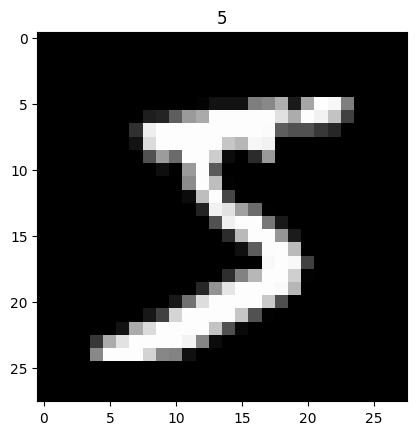

In [ ]:
## Visualization MNIST
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

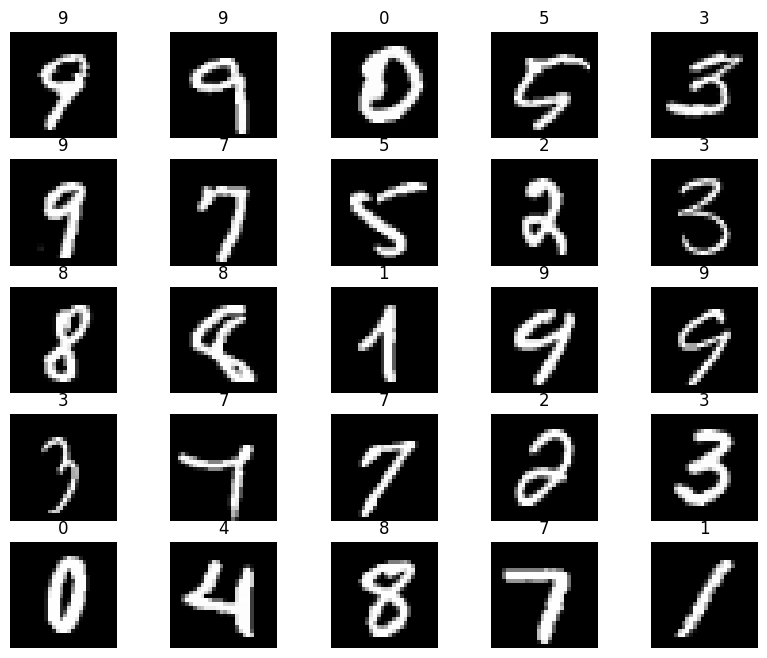

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x787d8698ea10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x787d8698ea70>}

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(
        #         in_channels=1,
        #         out_channels=16,
        #         kernel_size=5,
        #         stride=1,
        #         padding=2,
        #     ),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2),
        # )
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(16, 32, 5, 1, 2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        # )
        self.local_relational_layer = LocalRelationalLayer()

        # fully connected layer, output 10 classes
        self.local_relational_layer = LocalRelationalLayer(in_channels=32, out_channels=64, kernel_size=3)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.conv2(x)
        x = self.local_relational_layer(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
import torch
from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # Convert data to Variable
            b_x = Variable(images)   # Batch input
            b_y = Variable(labels)   # Batch labels

            # Forward pass
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # Clear gradients for this training step
            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            # Apply gradients
            optimizer.step()

            # Print every 100 steps
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

if __name__ == "__main__":
    num_epochs = 10
    train(num_epochs, cnn, loaders)


Epoch [1/10], Step [100/600], Loss: 0.3384
Epoch [1/10], Step [200/600], Loss: 0.0000
Epoch [1/10], Step [300/600], Loss: 0.1853
Epoch [1/10], Step [400/600], Loss: 0.0851
Epoch [1/10], Step [500/600], Loss: 0.0000
Epoch [1/10], Step [600/600], Loss: 0.2254
Epoch [2/10], Step [100/600], Loss: 0.0008
Epoch [2/10], Step [200/600], Loss: 0.0000
Epoch [2/10], Step [300/600], Loss: 0.0001
Epoch [2/10], Step [400/600], Loss: 0.0029
Epoch [2/10], Step [500/600], Loss: 0.0274
Epoch [2/10], Step [600/600], Loss: 0.0000
Epoch [3/10], Step [100/600], Loss: 0.0000
Epoch [3/10], Step [200/600], Loss: 0.0000
Epoch [3/10], Step [300/600], Loss: 0.0000
Epoch [3/10], Step [400/600], Loss: 0.0051
Epoch [3/10], Step [500/600], Loss: 0.0000
Epoch [3/10], Step [600/600], Loss: 0.0000
Epoch [4/10], Step [100/600], Loss: 0.0000
Epoch [4/10], Step [200/600], Loss: 0.0000
Epoch [4/10], Step [300/600], Loss: 0.0000
Epoch [4/10], Step [400/600], Loss: 0.0000
Epoch [4/10], Step [500/600], Loss: 0.0000
Epoch [4/10

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            # Do something with accuracy if needed
            print('Test Accuracy on the test set: {:.2%}'.format(accuracy))

if __name__ == "__main__":
    test()


Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 98.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 98.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 98.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 97.00%
Test Accuracy on the test set: 99.00%
Test Accuracy on the test set: 98.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 100.00%
Test Accuracy on the test set: 97.00%
Test 

In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [ ]:
actual_number = lbls[:10].numpy()
actual_number

array([5, 1, 8, 5, 4, 1, 6, 3, 1, 0])

In [ ]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 1 8 5 4 1 6 3 1 0]
Actual number: [5 1 8 5 4 1 6 3 1 0]
